# This project examines patterns in manufacturing defects

Data is provided by Bosch

## Import and examine the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

tic = time.process_time()

In [3]:
folder = 'Bosch-Production-Line-Performance/'
batch_size = 10000

In [4]:
%%time
# reading only first 10000 rows because of file size and memory limitations

train_categorical_sample = pd.read_csv(folder+'train_categorical.csv', nrows=batch_size)
train_numeric_sample = pd.read_csv(folder+'train_numeric.csv', nrows=batch_size)
train_date_sample = pd.read_csv(folder+'train_date.csv', nrows=batch_size)

<string>:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,41,42,43,57,59,60,62,63,65,66,68,69,71,72,74,75,77,78,80,81,83,84,86,87,89,90,92,93,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,188,189,190,191,192,193,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,335,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,464,467,470,473,476,479,482,485,488,491,494,497,500,5

CPU times: user 4.93 s, sys: 192 ms, total: 5.13 s
Wall time: 5.13 s


## Let's try to create a visualization of start and end for shopfloor

#### Question: Are Line #s and Station #s exclusive?  Or do there exist Station X for both Line A and B?

In [5]:
def extractLSF(string, isDate=False):
    '''
    Given a string in the Bosch Line/Station/Feature format (eg: L0_S0_F26), extract the Line number, Station number, and Feature number
    
    Input: String in Lx_Sy_Fz format
    
    Output:  Tuple of (x, y, z)
    
    Sidenote:  isDate will extract based on Lx_Sy_Dd format instead, returns tuple of (x, y, d)
    '''
    # first assert the format is correct:
    splitStr = string.split('_')
    if isDate:
        prefixList = ['L', 'S', 'D']
    else:
        prefixList = ['L', 'S', 'F']
        
    assert len(splitStr) == 3, 'Not 3 substrings split by "_"s!'
    for i in range(0, len(splitStr)):
        assert splitStr[i][1:].isnumeric(), 'Not numeric following the single-letter prefix!'
        assert splitStr[i][:1] == prefixList[i], 'Not the proper single-letter prefixes!  Did you use a Date format and forget to set isDate=True?'
    
    #now extract numbers:
    tempList = []
    
    for substr in splitStr:
        number = float(substr[1:])
        if number%1 == 0.0:
            tempList.append(int(number))
        else:
            tempList.append(number)
        
    return tuple(tempList)

In [6]:
def getListLSF(inputSeries, isDate=False):
    '''
    Given a series with fields of Bosch style Lx_Sy_Fz: Get the lines, stations, and features (or dates)
    Input:  series (row) in a Bosch-style QC matrix
    Output:  pandas dataframe of lines, stations, and features/dates
    '''
    
    for field in inputSeries.index:
        try:
            myL, myS, myF = extractLSF(field, isDate=isDate)
        except:
            continue
        listL.append(myL)
        listS.append(myS)
        listF.append(myF)
    
    return {'Lines': listL, 'Stations': listS, 'Features': listF}

In [7]:
def getListLSD(inputSeries):
    return getListLSF(inputSeries, isDate=True)

In [8]:
# All L/S/Fs

def get_lsf(lsf_df, isDate=False):
    '''From a Bosch DF, extract all the Line/Station/Feature combinations in the fields
    Outputs a Dataframe of columns Line, Station, Feature'''
    if isDate:
        lsf = pd.DataFrame(columns=['Line', 'Station', 'Date'])
    else:
        lsf = pd.DataFrame(columns=['Line', 'Station', 'Feature'])
    
    for field in lsf_df.columns:
        try:
            lsf = lsf.append(pd.DataFrame([list(extractLSF(field, isDate))], columns=lsf.columns))
        except:
            continue
    
    return lsf

# ----------------------------------------------------

cat_lsf = get_lsf(train_categorical_sample)
num_lsf = get_lsf(train_numeric_sample)
date_lsd = get_lsf(train_date_sample, isDate=True)

In [9]:
all_lsf = pd.concat([cat_lsf, num_lsf])

In [10]:
print(all_lsf.groupby('Line').min())
print(all_lsf.groupby('Line').max())

      Station  Feature
Line                  
0           0        0
1          24      675
2          26     3036
3          29     3315
      Station  Feature
Line                  
0          23      674
1          25     3034
2          28     3314
3          51     4262


#### It does look like the Line #s and Station #s are exclusive!

Looks like:

0. Line 0 encompasses Station 0 through 23
1. Line 1 encompasses Station 24 through 25
2. Line 2 encompasses Station 26 through 28
3. Line 3 encompasses Station 29 through 51

**We'll see in the test below that Line & Features, Station & Features, Line & Date, and Station & Date are ALL exclusive!!!**

In [11]:
def testLSFexclusive(data, groupbyfield, exclusivefield):
    '''Tests if the exclusiveField (eg: Stations) are exclusive to groupbyField (eg: Lines)
    Does this by ensuring there's no overlap in the min/max ranges'''
    mins = data.groupby(groupbyfield).min()[exclusivefield]
    maxs = data.groupby(groupbyfield).max()[exclusivefield]
    
    bool1 = mins[0] == mins.min()
    bool2 = maxs[-1:].iloc[0] == maxs.max()
    bool3 = True
    
    for i in range(0, mins.size-1):
        if maxs[i] >= mins[i+1]: #careful i is last one
            bool3 = False
    
    return bool1*bool2*bool3

In [12]:
print( testLSFexclusive(all_lsf, 'Line', 'Feature') )
print( testLSFexclusive(all_lsf, 'Station', 'Feature') )
print( testLSFexclusive(date_lsd, 'Line', 'Date') )
print( testLSFexclusive(date_lsd, 'Station', 'Date') )

True
True
True
True


## Now we can produce a shop floor picture because we know that lines, stations, features, and dates don't overlap across each other!

In [13]:
# station_line_assignment is a Dictionary of Stations with their respective Lines

station_line_assignment = all_lsf.groupby('Station').min().drop('Feature', axis=1)

tempdict = {-1:-1} #assign Start station as a Start type
for i in station_line_assignment.index:
    tempdict[i] = station_line_assignment.loc[i][0]
tempdict[99] = 99 #assign Pass result station as Result Line
tempdict[100] = 100 #assign Fail result station as Result Line

station_line_assignment = tempdict

In [14]:
# Creating color codes for Nodes:  Different Lines, Outputs, and Starting Point all have different colors:

#-1=start, 999999=Result, everything else=Line#

nodeColorDict = {0:'blue', 1:'red', 2:'green', 3:'orange', -1:'gold', 99:'purple', 100:'purple'}

#### Creating arguments to feed in Network.add_nodes

In [15]:
nodesList = list(station_line_assignment.keys())
nodesLabelList = ['S{}'.format(station) for station in nodesList]
#nodesSizeList = # <--- temporary, I will create this list in few lines of code down
nodesColorList = [nodeColorDict[station_line_assignment[station]] for station in nodesList]

In [16]:
# create new dataframe to ready to get all connections
# this dataframe shows stations only in the Field Names... stations are the only thing I need for connections

dateColsStationOnly = ['Id']
dateColsStationOnly.extend((list(date_lsd['Station'])))

train_date_sample_stationcols = train_date_sample.copy()
train_date_sample_stationcols.columns = dateColsStationOnly

In [17]:
# it seems like there's duplicate station fields.  But they all have the same values... or do they?

for stationNum in train_date_sample_stationcols.columns.unique().drop('Id'):
    if len(train_date_sample_stationcols[stationNum].shape)==1:
        continue
    diff = (train_date_sample_stationcols[stationNum].max(axis=1)-train_date_sample_stationcols[stationNum].min(axis=1)).max()
    if round(diff, 5) != 0:
        print(stationNum, diff)
        
# Results:

    # Station 24 has 288 different Features (it's a big station), so there was probably a lot of time taken here
    # Station 25 has 333 different Features (it's a big station), so there was probably a lot of time taken here as well
    # Station 42 has no operations taken here (out of the first 10000 samples), so we have an NaN value

24 0.8799999999999955
25 19.850000000000136
42 nan


In [18]:
# so now we know we can consolidate the station fields into 1, let's do that, and create a new DataFrame:

df = pd.DataFrame(columns=train_date_sample_stationcols.columns.unique())
df['Id'] = train_date_sample_stationcols['Id']

for stationNum in df.drop('Id', axis=1):
    if len(train_date_sample_stationcols[stationNum].shape)==1: #if only 1 column
        df[stationNum] = train_date_sample_stationcols[stationNum]
        continue
    df[stationNum] = train_date_sample_stationcols[stationNum].mean(axis=1)
    

train_date_sample_stationcols_unique = df

In [19]:
# append 'Response' to the back

train_date_sample_stationcols_unique[99] = train_numeric_sample['Response'].apply(lambda x: 999999 if x==0 else np.nan)
train_date_sample_stationcols_unique[100] = train_numeric_sample['Response'].apply(lambda x: 999999 if x==1 else np.nan)

In [20]:
train_date_sample_stationcols_unique.tail()

,Id,0,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,99,100
9995,19912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999.0,NaN
9996,19915,904.17,904.17,NaN,904.18,NaN,904.19,NaN,904.20,904.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999.0,NaN
9997,19917,640.60,640.60,640.6,NaN,NaN,640.61,NaN,640.62,640.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999.0,NaN
9998,19921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999.0,NaN
9999,19923,1379.75,1379.75,NaN,1379.75,1379.77,NaN,1379.77,NaN,1379.78,...,1380.49,1380.58,NaN,1380.59,1380.59,1380.59,NaN,1380.59,999999.0,NaN


In [21]:
# Creating a list of sizes, based on how frequently the stations are hit:
# nodesSizeList
import math

def getNodesSizeList(dfStationCols, scalar=1, islog=False):
    maximumValue = dfStationCols.shape[0]
    if islog:
        nodesSizeList = [math.log(dfStationCols[stationNum].dropna().size*scalar/maximumValue+1) 
                 for stationNum in dfStationCols.columns]
    else:
        nodesSizeList = [dfStationCols[stationNum].dropna().size*scalar/maximumValue+1 
                 for stationNum in dfStationCols.columns]
    
    return nodesSizeList
    
#-----------------------------------

nodesSizeList = getNodesSizeList(train_date_sample_stationcols_unique, scalar=50000, islog=True)
#nodesSizeList = getNodesSizeList(train_date_sample_stationcols_unique, scalar=5, islog=False)

In [22]:
# now we create connections, based on train_date_sample_stationcols_unique: we can see sequence of movement between stations:

def getConnections(inputSeries):
    '''
    Get a list of tuples for all connections, starting from -1 (Start), and ending at either 99 (Pass), or 100 (Fail)
    
    Input:  A Series with a lot of NaNs, and indexes are Station Names (integers)
    
    Output: A List of Tuples with all connections of Pairs of Adjacent Stations without NaNs
    '''
    droppedNa = list(inputSeries.dropna().drop('Id').index)
    listOfConnections = [(-1,droppedNa[0])]
    for i in range(0, len(droppedNa)-1):
        listOfConnections.append((droppedNa[i],droppedNa[i+1]))
    return listOfConnections    


def flattenConnectionsSeries(connectionsSeries):
    mylist = []
    for item in connectionsSeries:
        mylist.extend(item)
    return mylist

In [23]:
# Connection Frequency will list all the connections and their corresponding (not-normalized) frequencies
# Not too important yet... below will be the Normalized version which is VERY important

allConnections = train_date_sample_stationcols_unique.apply(getConnections, axis=1)
allConnections = flattenConnectionsSeries(allConnections)

from collections import Counter
connectionFrequency = Counter(allConnections)

#connectionFrequency

In [24]:
import math

def normalizeFrequencyDict(frequencyDict, scalar=1, islog=False):
    maximumValue = max(frequencyDict.values())
    newDict = {}
    
    for key in frequencyDict:
        if islog:
            newDict[key] = math.log(frequencyDict[key]*scalar/maximumValue)
        else:
            newDict[key] = frequencyDict[key]*scalar/maximumValue
    
    return newDict 


def convertFrequencyDictToFrequencyList(frequencyDict):
    return [(key[0], key[1], frequencyDict[key]) for key in frequencyDict.keys()]

#### Creating arguments to feed in Network.add_edges (incl. thickness)

In [25]:
# Normalized connection frequency
# EXTREMELY IMPORTANT - this is what the nodes-edges will be for the node graph

normConnectionFrequency = normalizeFrequencyDict(connectionFrequency, scalar=100, islog=True)

nodesEdgeList = convertFrequencyDictToFrequencyList(normConnectionFrequency)

## Now let's graph this Shop Layout!

In [26]:
from pyvis import network as net
import networkx as nx #for graphing nodes

g = net.Network(height='1800px', width='1200px', notebook=False, layout=0) #creating node graph object

g.add_nodes(nodesList, 
            label=nodesLabelList, 
            color=nodesColorList,
           size=nodesSizeList) #creating nodes

#nodesEdgeList.sort()

g.add_edges(nodesEdgeList) #creating edges (thickness is the 3rd optional argument)

g.show_buttons(filter_=['physics'])

g.show('mygraph.html') #generating the graph and showing it

# Testing below

In [90]:
type(train_date_sample_stationcols_unique.iloc[0])

pandas.core.series.Series

In [91]:
list(train_date_sample_stationcols_unique.iloc[0].dropna().drop('Id').index)

[0, 1, 2, 4, 7, 8, 11, 29, 30, 31, 33, 34, 35, 37, 99]

In [92]:
getConnections(train_date_sample_stationcols_unique.iloc[0])

[(-1, 0),
 (0, 1),
 (1, 2),
 (2, 4),
 (4, 7),
 (7, 8),
 (8, 11),
 (11, 29),
 (29, 30),
 (30, 31),
 (31, 33),
 (33, 34),
 (34, 35),
 (35, 37),
 (37, 99)]

In [41]:
#reference for creating node graph:

g = net.Network(height='500px', width='100%', notebook=True, layout=0) #creating node graph object

g.add_nodes([35, 56, 79, 100]) #creating nodes

g.add_edges([(35,56), (56,79), (35,79,10)]) #creating edges (thickness is the 3rd optional argument)

g.show('mygraph.html') #generating the graph and showing it

In [43]:
#  Trying out networkx node graph

nodesEdgeList

[(-1, 0, 4.105182780589676),
 (-1, 1, -2.6029013032633936),
 (-1, 12, 3.0908308355393057),
 (-1, 24, 2.7624069321009213),
 (-1, 25, 1.9173332719189122),
 (-1, 26, -4.548811452318707),
 (-1, 27, -2.1509161795203364),
 (-1, 29, -1.3707576219707613),
 (-1, 38, -3.8556642717587617),
 (-1, 99, -3.4501991636505975),
 (0, 1, 4.1039610333393535),
 (0, 2, -3.1625170911988163),
 (0, 3, -3.4501991636505975),
 (1, 2, 3.4045068942417243),
 (1, 3, 3.4181220460861326),
 (1, 4, -3.8556642717587617),
 (1, 5, -3.8556642717587617),
 (2, 3, -4.548811452318707),
 (2, 4, 2.706073357758631),
 (2, 5, 2.718713975509465),
 (3, 4, 2.688966739604736),
 (3, 5, 2.7624069321009213),
 (4, 5, -4.548811452318707),
 (4, 6, 2.711711145771145),
 (4, 7, 2.683921683858908),
 (5, 6, 2.728436274312777),
 (5, 7, 2.7550317729589975),
 (6, 8, 3.411163075761829),
 (6, 10, -4.548811452318707),
 (6, 11, -2.9393735398846066),
 (7, 8, 3.41186115606941),
 (7, 9, -4.548811452318707),
 (7, 11, -3.4501991636505975),
 (8, 9, 2.99921751761

In [45]:
froms = [tup[0] for tup in nodesEdgeList]
tos = [tup[1] for tup in nodesEdgeList]

df = pd.DataFrame({ 'from':froms, 'to':tos})

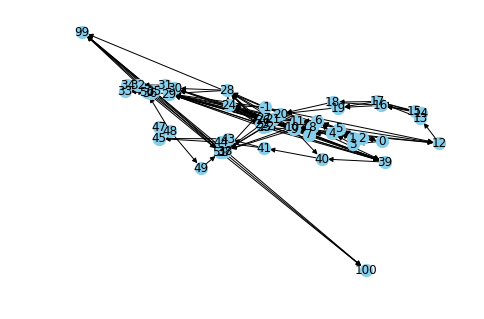

In [56]:
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.DiGraph())
 
# Fruchterman Reingold
nx.draw(G, with_labels=True, node_size=150, node_color="skyblue", pos=nx.fruchterman_reingold_layout(G))